In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

params = {'axes.labelsize'  : 14.5,
          'axes.titlesize'  : 14.5,
          'font.size'       : 13,
          'legend.fontsize' : 13,
          'xtick.labelsize' : 14.5,
          'ytick.labelsize' : 14.5}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

*RQ1:* How much effort does it take for human annotators to generate segmentations for cell images of varying detail using GrabCut as an interactive segmentation approach?

Effort:

* Mean maximum `submission_counter` per `image_id`
* Time per submission per `image_id` per `session_id`
* For Kromp dataset: Percentage of annotated pixels compared to ground truth mask.

In [2]:
# q = '''
#     select
#         interaction_uuid,
#         interactions.session_id,
#         interactions.image_id,
#         annotated_pixels,
#         foreground_pixels,
#         background_pixels,
#         scribbles,
#         foreground_scribbles,
#         background_scribbles,
#         submission_counter,
#         first_interaction_time,
#         submission_time
#     from interactions, masks
#     where interactions.session_id = masks.session_id
# '''
q = '''select * from interactions'''
conn = sqlite3.connect('grabcutstudy.db')

interactions_df = pd.read_sql_query('''select * from interactions''', conn, parse_dates=['first_interaction_time', 'submission_time'])
masks_df = pd.read_sql_query('''select * from masks''', conn)

conn.close()

In [3]:
print(f'IAR: \t{len(interactions_df)} segmentations requested')
print(f'Masks: \t{len(masks_df)} masks created')

IAR: 	642 segmentations requested
Masks: 	233 masks created


In [4]:
# Images that have been worked on
requested_images = interactions_df['image_id'].unique()
print(f"{requested_images} -- {len(requested_images)} out of 13 have been requested by all participants so far")

['lym17' 'neu12' 'agg185' 'normal2' 'lym0' 'neu90' 'agg23' 'neurblas10'
 'neu0' 'neurblas5' 'agg17' 'normal4' 'neurblas16'] -- 13 out of 13 have been requested by all participants so far


In [5]:
from datetime import datetime
import time

now = time.time()
offset = datetime.fromtimestamp(now) - datetime.utcfromtimestamp(now)

def utc_to_local(utc_datetime, offset=offset):
    localtime = (utc_datetime + offset).time()
    d = datetime.strptime(localtime, '%Y-%m-%d %H:%M:%S')
    return d.strftime('%Y-%m-%d %H:%M:%S')

def format_time(time):
    return time.strftime('%Y-%m-%d %H:%M:%S')

interactions_df['first_interaction_time'] = interactions_df['first_interaction_time'] + pd.Timedelta(2, unit='h')
interactions_df['first_interaction_time'] = interactions_df['first_interaction_time'].apply(format_time)

interactions_df['submission_time'] = interactions_df['submission_time'] + pd.Timedelta(2, unit='h')
interactions_df['submission_time'] = interactions_df['submission_time'].apply(format_time)

image_categories = ['lym0', 'lym17', 'neu0', 'neu12', 'neu90', 'agg17', 'agg23', 'agg185', 'neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']
imgs = pd.api.types.CategoricalDtype(ordered=True, categories=image_categories)

interactions_df['image_id'] = interactions_df['image_id'].astype(imgs)

In [6]:
# Only process images where the participants have actually submitted their mask
finished_df = pd.merge(interactions_df, masks_df, how="inner", on=["session_id", "image_id"])
print(f'{len(finished_df)} segmentations requested given that a final mask choice was submitted.')

610 segmentations requested given that a final mask choice was submitted.


In [7]:
final_submission_idx = finished_df.groupby(['session_id', 'image_id'])['submission_counter'].transform(max) == finished_df['submission_counter']
df_final_interaction_per_image_per_session = finished_df[final_submission_idx]
df_final_interaction_per_image_per_session = df_final_interaction_per_image_per_session.rename(columns={'submission_counter': 'total_submissions'})

In [8]:
# df_max_submission_per_image_per_session = finished_df.groupby(['session_id', 'image_id']).max().reset_index(level='image_id').reset_index(drop=True).rename({'submission_counter': 'total_submissions'})
# df_final_interaction_per_image_per_session = finished_df.groupby(['session_id', 'image_id'], as_index=False).max()
#
# del df_final_interaction_per_image_per_session['annotated_pixels']
# del df_final_interaction_per_image_per_session['foreground_pixels']
# del df_final_interaction_per_image_per_session['background_pixels']
# del df_final_interaction_per_image_per_session['scribbles']
# del df_final_interaction_per_image_per_session['foreground_scribbles']
# del df_final_interaction_per_image_per_session['background_scribbles']
#
# df_final_interaction_per_image_per_session = df_final_interaction_per_image_per_session.rename(columns={
#     'submission_counter': 'total_submissions'
# })
#
# df_final_interaction_per_image_per_session.head()

In [9]:
print(f'We are considering {len(df_final_interaction_per_image_per_session)} interactions where the mask was submitted.')

We are considering 231 interactions where the mask was submitted.


In [10]:
df_final_interaction_per_image_per_session['first_interaction_time'] = pd.to_datetime(df_final_interaction_per_image_per_session['first_interaction_time'])
df_final_interaction_per_image_per_session['submission_time'] = pd.to_datetime(df_final_interaction_per_image_per_session['submission_time'])

df_final_interaction_per_image_per_session['interaction_duration'] = df_final_interaction_per_image_per_session['submission_time'] - df_final_interaction_per_image_per_session['first_interaction_time']

In [11]:
# df_total_submissions_per_image_per_session.drop('first_interaction_time', axis=1, inplace=True)
# df_total_submissions_per_image_per_session.drop('submission_time', axis=1, inplace=True)

In [12]:
# df_mean_submission_per_image_per_session = df_max_submission_per_image_per_session.groupby('image_id').agg({'interaction_duration': [('mean_interaction_duration', 'mean')]})

In [13]:
df_interaction_time_per_image_per_session = df_final_interaction_per_image_per_session[['image_id', 'interaction_duration', 'mask_uuid']]
df_submissions_per_image_per_session = df_final_interaction_per_image_per_session[['image_id', 'total_submissions']]

In [14]:
df_interaction_time_per_image_per_session['interaction_duration_seconds'] = df_interaction_time_per_image_per_session['interaction_duration'].dt.total_seconds()
# df_interaction_time_per_image_per_session

<ipython-input-14-17aa28231d43>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interaction_time_per_image_per_session['interaction_duration_seconds'] = df_interaction_time_per_image_per_session['interaction_duration'].dt.total_seconds()


### Time per submission per `image_id` per `session_id`

<ipython-input-15-72f066f2b019>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interaction_time_per_image_per_session['image_id'] = df_interaction_time_per_image_per_session['image_id'].astype(imgs)


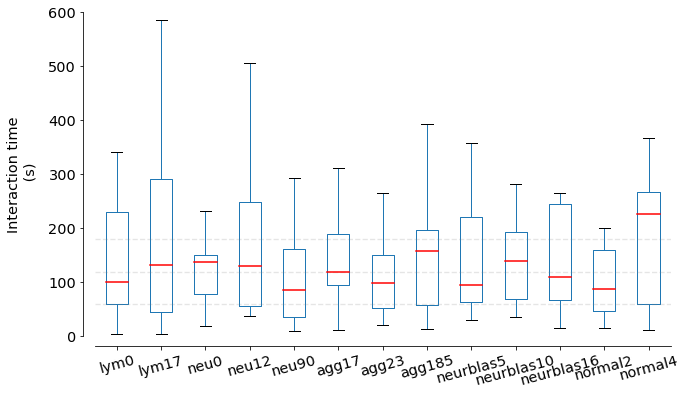

In [15]:
df_interaction_time_per_image_per_session['image_id'] = df_interaction_time_per_image_per_session['image_id'].astype(imgs)

fig, ax = plt.subplots(figsize=(10, 6))

bp = df_interaction_time_per_image_per_session.boxplot(
    column=['interaction_duration_seconds'],
    by='image_id',
    ax=ax,
    sym='',
    medianprops={'linewidth': 1.5},
    return_type='dict',
)

for key in bp.keys():
    for item in bp[key]['medians']:
        item.set_color('red')

plt.grid(b=False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.03))
ax.spines['left'].set_position(('axes', -0.02))

ax.axhline(60, color='grey', alpha=0.2, linestyle='dashed', linewidth=1.4)
ax.axhline(120, color='grey', alpha=0.2, linestyle='dashed', linewidth=1.4)
ax.axhline(180, color='grey', alpha=0.2, linestyle='dashed', linewidth=1.4)

fig.canvas.draw()

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Interaction time\n (s)')
ax.yaxis.labelpad = 11

fig.suptitle('')
ax.set_ylim([0, 600])

plt.xticks(rotation=15)
plt.show()

* Limitation: We can't control if people take breaks during the labeling session, this affects the interaction time per image...

### Submissions per `image_id` per `session_id`

<ipython-input-16-3f7b7f55c550>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submissions_per_image_per_session['image_id'] = df_submissions_per_image_per_session['image_id'].astype(imgs)


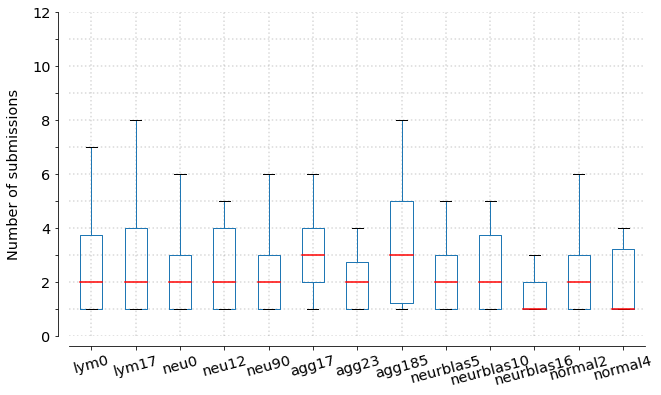

In [16]:
df_submissions_per_image_per_session['image_id'] = df_submissions_per_image_per_session['image_id'].astype(imgs)

fig, ax = plt.subplots(figsize=(10, 6))

bp = df_submissions_per_image_per_session.boxplot(
    column=['total_submissions'],
    by='image_id',
    ax=ax,
    sym='',
    medianprops={'linewidth': 1.5},
    return_type='dict',
)

for key in bp.keys():
    for item in bp[key]['medians']:
        item.set_color('red')

# ax.grid(False)
plt.grid(b=True, color='grey', alpha=0.3, linestyle='dotted', linewidth=1.5)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.03))
ax.spines['left'].set_position(('axes', -0.02))

fig.canvas.draw()

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Number of submissions')
ax.yaxis.labelpad = 11
ax.yaxis.set_ticks(range(0, 13, 1))

y_labels = [item.get_text() for item in ax.get_yticklabels()]

# print(ax.get_yticklabels())
# print(y_labels)

new_y_labels = [
    '' if i % 2 != 0 else str(i) for i in range(len(y_labels))]
ax.set_yticklabels(new_y_labels)

fig.suptitle('')

plt.xticks(rotation=15)
plt.show()

### Percentage of annotated pixels compared to ground truth

In [17]:
kromp_gt = np.load('kromp_gt.npz')

# keys = ['neurblas5', 'neurblas16', 'neurblas10', 'normal2', 'normal4']

d = {
    'image_id': ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4'],
    'bg_pixels': [
        np.count_nonzero(kromp_gt['neurblas5'] == 0),
        np.count_nonzero(kromp_gt['neurblas10'] == 0),
        np.count_nonzero(kromp_gt['neurblas16'] == 0),
        np.count_nonzero(kromp_gt['normal2'] == 0),
        np.count_nonzero(kromp_gt['normal4'] == 0),
    ],
    'fg_pixels': [
        np.count_nonzero(kromp_gt['neurblas5'] == 1),
        np.count_nonzero(kromp_gt['neurblas10'] == 1),
        np.count_nonzero(kromp_gt['neurblas16'] == 1),
        np.count_nonzero(kromp_gt['normal2'] == 1),
        np.count_nonzero(kromp_gt['normal4'] == 1),
    ],
}

gt_pixels_df = pd.DataFrame(data=d)

gt_pixels_df.head()

,image_id,bg_pixels,fg_pixels
0,neurblas5,174842,21766
1,neurblas10,179498,17110
2,neurblas16,183531,13077
3,normal2,158889,37719
4,normal4,178095,18513


In [18]:
gt_percentages_df = pd.merge(df_final_interaction_per_image_per_session, gt_pixels_df, how="inner", on="image_id")

gt_percentages_df = gt_percentages_df.rename(
    columns={'bg_pixels': 'background_pixels_gt', 'fg_pixels': 'foreground_pixels_gt'}
    # inplace=True
)

In [23]:
gt_percentages_df['annotated_fg_pixels_percentage'] = gt_percentages_df['foreground_pixels'] / gt_percentages_df['foreground_pixels_gt']

gt_percentages_df['annotated_bg_pixels_percentage'] = gt_percentages_df['background_pixels'] / gt_percentages_df['background_pixels_gt']

In [24]:
kromp_image_categories = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']
kromp_imgs = pd.api.types.CategoricalDtype(ordered=True, categories=kromp_image_categories)

gt_percentages_df['image_id'] = gt_percentages_df['image_id'].astype(kromp_imgs)

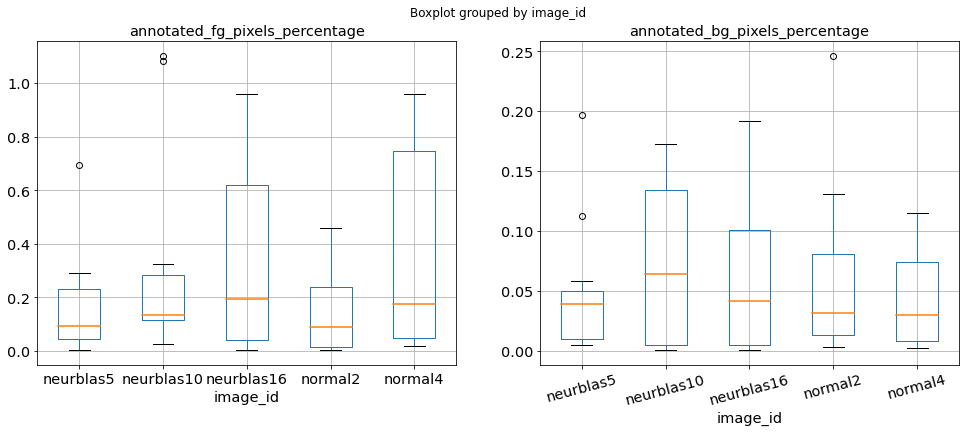

[Text(1, 0, 'neurblas5'), Text(2, 0, 'neurblas10'), Text(3, 0, 'neurblas16'), Text(4, 0, 'normal2'), Text(5, 0, 'normal4')]


In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

bp1 = gt_percentages_df.boxplot(
    column=['annotated_fg_pixels_percentage'],
    by='image_id',
    ax=ax[0],
    # sym='',
    medianprops={'linewidth': 1.5},
    return_type='dict',
)

bp2 = gt_percentages_df.boxplot(
    column=['annotated_bg_pixels_percentage'],
    by='image_id',
    ax=ax[1],
    # sym='',
    medianprops={'linewidth': 1.5},
    return_type='dict',
)

plt.xticks(rotation=15)
plt.show()

print(ax[0].get_xticklabels())

all_fg_y_whiskers = [whiskers.get_ydata()[1] for i, whiskers in enumerate(bp1['annotated_fg_pixels_percentage']['whiskers'])]
all_bg_y_whiskers = [whiskers.get_ydata()[1] for i, whiskers in enumerate(bp2['annotated_bg_pixels_percentage']['whiskers'])]

fg_whiskers_min = []
fg_whiskers_max = []

for i, y_val in enumerate(all_fg_y_whiskers):
    if i % 2 == 0: fg_whiskers_min.append(y_val)
    else: fg_whiskers_max.append(y_val)

bg_whiskers_min = []
bg_whiskers_max = []

for i, y_val in enumerate(all_bg_y_whiskers):
    if i % 2 == 0: bg_whiskers_min.append(y_val)
    else: bg_whiskers_max.append(y_val)

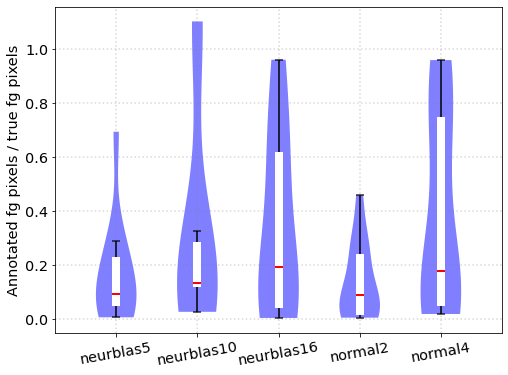

In [26]:
# def adjacent_values(vals, q1, q3):
#     iqr = q3 - q1
#     dist_above_iqr = q3 + 1.5 * iqr
#     dist_above_iqr = np.clip(dist_above_iqr, q3, vals[-1])
#
#     dist_below_iqr = q1 - 1.5 * iqr
#     dist_below_iqr = np.clip(dist_below_iqr, vals[0], q1)
#
#     insert_idx_higher_whisker = np.searchsorted(vals, dist_above_iqr, side='left')
#     insert_idx_lower_whisker = np.searchsorted(vals, dist_below_iqr, side='right')
#
#     if insert_idx_higher_whisker >= len(vals):
#         higher_whisker = vals[len(vals) - 1]
#     elif insert_idx_higher_whisker == 0:
#         higher_whisker = vals[0]
#     else:
#         higher_whisker = vals[insert_idx_higher_whisker - 1]
#
#     if insert_idx_lower_whisker >= len(vals):
#         lower_whisker = vals[len(vals) - 1]
#     elif insert_idx_lower_whisker == 0:
#         lower_whisker = vals[0]
#     else:
#         lower_whisker = vals[insert_idx_lower_whisker]
#
#     return lower_whisker, higher_whisker

x_labels = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']

fg_data = [
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'neurblas5']["annotated_fg_pixels_percentage"].values),
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'neurblas10']["annotated_fg_pixels_percentage"].values),
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'neurblas16']["annotated_fg_pixels_percentage"].values),
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'normal2']["annotated_fg_pixels_percentage"].values),
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'normal4']["annotated_fg_pixels_percentage"].values)
]

max_values_length = max([vals.size for vals in fg_data])
fg_data_sorted_padded = [
    np.sort(np.pad(vals, pad_width=(0, max_values_length - vals.size), mode='constant', constant_values=np.nan))
    for vals in fg_data
]

bg_data = [
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'neurblas5']["annotated_bg_pixels_percentage"].values),
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'neurblas10']["annotated_bg_pixels_percentage"].values),
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'neurblas16']["annotated_bg_pixels_percentage"].values),
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'normal2']["annotated_bg_pixels_percentage"].values),
    np.sort(gt_percentages_df[gt_percentages_df.image_id == 'normal4']["annotated_bg_pixels_percentage"].values)
]

max_values_length = max([vals.size for vals in bg_data])
bg_data_sorted_padded = [
    np.sort(np.pad(vals, pad_width=(0, max_values_length - vals.size), mode='constant', constant_values=np.nan))
    for vals in bg_data
]

fig, ax = plt.subplots(figsize=(8, 6))

vp = ax.violinplot(dataset=fg_data,
                  showmeans=False,
                  showmedians=False,
                  showextrema=False)

for pc in vp['bodies']:
    pc.set_facecolor('#0000ff')
    # pc.set_edgecolor('black')
    pc.set_alpha(0.5)

quartile1, medians, quartile3 = np.nanpercentile(fg_data_sorted_padded, [25, 50, 75], axis=1)
# whiskers = np.array([
#     adjacent_values(sorted_array, q1, q3)
    # for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
# whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, fg_whiskers_min, marker="_", color='k', s=50, zorder=3, alpha=0.8)
ax.scatter(inds, fg_whiskers_max, marker="_", color='k', s=50, zorder=3, alpha=0.8)
ax.vlines(inds, fg_whiskers_min, fg_whiskers_max, color='k', linestyle='-', lw=1.5)
ax.vlines(inds, quartile1, quartile3, color='w', linestyle='-', lw=8)
ax.scatter(inds, medians, marker="_", color='r', s=80, linewidths=2, zorder=3)
# ax.vlines(inds, whiskers_min, whiskers_max, color='#165683', linestyle='-', lw=1, alpha=0.7)

ax.set_ylabel('Annotated fg pixels / true fg pixels')

ax.set_xticks(np.arange(1, len(x_labels) + 1))
ax.set_xticklabels(x_labels, rotation=10)
ax.set_xlim(0.25, len(x_labels) + 0.75)

plt.grid(b=True, color='grey', alpha=0.3, linestyle='dotted', linewidth=1.5)
plt.show()

In [27]:
#TODO find out who colored more than 100% of the foreground pixels

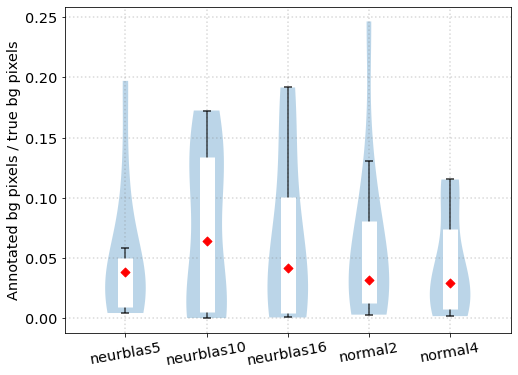

In [28]:
x_labels = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']

fig, ax = plt.subplots(figsize=(8, 6))

vp = ax.violinplot(dataset = bg_data,
                      showmeans=False,
                      showmedians=False,
                      showextrema=False)

for pc in vp['bodies']:
    pc.set_facecolor('#1f77b4')
    # pc.set_edgecolor('black')
    pc.set_alpha(0.3)

quartile1, medians, quartile3 = np.nanpercentile(bg_data_sorted_padded, [25, 50, 75], axis=1)
# whiskers = np.array([
#     adjacent_values(sorted_array, q1, q3)
# for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
# whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, bg_whiskers_min, marker="_", color='k', s=50, zorder=3, alpha=0.8)
ax.scatter(inds, bg_whiskers_max, marker="_", color='k', s=50, zorder=3, alpha=0.8)
ax.vlines(inds, bg_whiskers_min, bg_whiskers_max, color='k', linestyle='-', lw=1.5, alpha=0.7)
ax.vlines(inds, quartile1, quartile3, color='white', linestyle='-', lw=15)
ax.scatter(inds, medians, marker="D", color='red', s=40, zorder=3)
# ax[0].vlines(inds, whiskers_min, whiskers_max, color='#165683', linestyle='-', lw=1, alpha=0.7)

ax.set_ylabel('Annotated bg pixels / true bg pixels')

ax.set_xticks(np.arange(1, len(x_labels) + 1))
ax.set_xticklabels(x_labels, rotation=10)
ax.set_xlim(0.25, len(x_labels) + 0.75)

plt.grid(b=True, color='grey', alpha=0.3, linestyle='dotted', linewidth=1.5)
plt.show()